# [5] Assignment 3: KNN

# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import normalize
import collections
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split



"""
#Ref: https://www.youtube.com/watch?v=Gol_qOgRqfA&t=141s
from sklearn.model_selection import GridSearchCV
def BestkBrute(xtr_,ytr_,kfold,j): #nn:Max # neighbors, k-fold: kfold cross validation, j:#jobs to run in parallel
    knn = KNeighborsClassifier(algorithm='brute', n_jobs=j)
    param_grid = {'n_neighbors':kt}
    grid = GridSearchCV(knn, param_grid, cv=kfold, n_jobs=j, scoring='roc_auc', return_train_score=True)
    grid.fit(xtr_,ytr_)
    return grid
"""

kt=[1,11,21,31,41,51,61,71,81,91,101,111,131,151,171,191,211,251,301]
#ka=[1,11,21,31,41,51,61,71,81]
def BestkBrute(xtr_,ytr_,xcv_,ycv_,j): #nn:Max # neighbors, k-fold: kfold cross validation, j:#jobs to run in parallel
    train_auc = []
    cv_auc = []
    cv_score = []
    for i in kt:
        knn = KNeighborsClassifier(n_neighbors=i, n_jobs=j, algorithm='brute')
        knn.fit(xtr_, ytr_)
        # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
        # not the predicted outputs
        ytr_pre =  knn.predict_proba(xtr_)[:,1]
        ycv_pre =  knn.predict_proba(xcv_)[:,1]
    
        train_auc.append(roc_auc_score(ytr,ytr_pre))
        cvroc = roc_auc_score(ycv, ycv_pre)
        cv_auc.append(cvroc)
        cv_score.append({i:cvroc})
    fig = plt.figure()
    plt.plot(kt, train_auc, label='Train AUC')
    plt.plot(kt, cv_auc, label='CV AUC')
    plt.legend()
    plt.xlabel("K: Hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS",figure=fig)
    return fig,cv_score;


def BestkKD(xtr_,ytr_,xcv_,ycv_,j): #nn:Max # neighbors, k-fold: kfold cross validation, j:#jobs to run in parallel
    train_auc = []
    cv_auc = []
    cv_score = []
    for i in kt:
        knn = KNeighborsClassifier(n_neighbors=i, n_jobs=j, algorithm='kd_tree')
        knn.fit(xtr_, ytr_)
        # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
        # not the predicted outputs
        ytr_pre =  knn.predict_proba(xtr_)[:,1]
        ycv_pre =  knn.predict_proba(xcv_)[:,1]
    
        train_auc.append(roc_auc_score(ytr_,ytr_pre))
        cvroc = roc_auc_score(ycv_, ycv_pre)
        cv_auc.append(cvroc)
        cv_score.append({i:cvroc})
    fig = plt.figure()
    plt.plot(kt, train_auc, label='Train AUC')
    plt.plot(kt, cv_auc, label='CV AUC')
    plt.legend()
    plt.xlabel("K: Hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS",figure=fig)
    return fig,cv_score;



#Ref: https://stackoverflow.com/questions/8955448/save-load-scipy-sparse-csr-matrix-in-portable-data-format
#Ref: https://docs.python.org/3/library/pickle.html
#Ref: https://stackoverflow.com/questions/27745500/how-to-save-a-list-to-a-file-and-read-it-as-a-list-type
#Ref: https://github.com/ipython/ipykernel/issues/231

from scipy import sparse
def ToDiskM(data,name):
    file=open(name+'.npz', 'wb')
    sparse.save_npz(file, data, compressed=True)
    file.close()
    
def FromDiskM(name):
    file = sparse.load_npz(name+".npz")
    return file


def ToDiskP(data,name):
    with open(name+".txt", "wb") as fp, plt.rc_context(rc={'interactive': False}):   #Pickling
        pickle.dump(data, fp)
def FromDiskP(name):
    with open(name+".txt", "rb") as fp, plt.rc_context(rc={'interactive': False}):   # Unpickling
        file = pickle.load(fp)
    return file

print('success')

success


# [1]. Reading Data

In [124]:
%%time

try:
    final=FromDiskP('preprocessed_data100k')
    xtr=FromDiskP('xtr_100k')
    xte=FromDiskP('xte_100k')
    ytr=FromDiskP('ytr_100k')
    yte=FromDiskP('yte_100k')
    xcv=FromDiskP('xcv_100k')
    ycv=FromDiskP('ycv_100k')
    #print('Load Successful.')
    print('Load Successful.')

except:
    # using the SQLite Table to read data.
    con = sqlite3.connect('..\data\database.sqlite') 
    filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
    # Give reviews with Score>3 a positive rating:1 , and reviews with a score<3 a negative rating:0.
    def partition(x):
        if x < 3:
            return 0
        return 1

    #changing reviews with score less than 3 to be positive and vice-versa
    filtered_data['Score']= filtered_data['Score'].map(partition)
    print("Number of data points in our data", filtered_data.shape)
    data_p=filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
    #Checking to see how much % of data still remains
    data_p=data_p[data_p.HelpfulnessNumerator<=data_p.HelpfulnessDenominator]
    print('Percentage of data left:',(data_p['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100)
    print('Shape of data:',data_p.shape)
    #data_p['Score'].value_counts()
    sn=25000
    sample0 = data_p[data_p['Score']==0].sample(sn, random_state=39)
    sample1 = data_p[data_p['Score']==1].sample(sn, random_state=39)
    #final = data_p.sample(20000)
    final = pd.concat([sample0,sample1])
    #print(final['Score'].value_counts())
    #https://stackoverflow.com/questions/42462935/how-to-sort-by-timestamps-in-pandas
    final['Time']=pd.to_datetime(final["Time"],unit='s')
    #print(final.head(1))
    final.sort_values(by='Time',inplace=True)
    
    # https://stackoverflow.com/a/47091490/4084039

    def decontracted(phrase):
        # specific
        phrase = re.sub(r"won't", "will not", phrase)
        phrase = re.sub(r"can\'t", "can not", phrase)
        # general
        phrase = re.sub(r"n\'t", " not", phrase)
        phrase = re.sub(r"\'re", " are", phrase)
        phrase = re.sub(r"\'s", " is", phrase)
        phrase = re.sub(r"\'d", " would", phrase)
        phrase = re.sub(r"\'ll", " will", phrase)
        phrase = re.sub(r"\'t", " not", phrase)
        phrase = re.sub(r"\'ve", " have", phrase)
        phrase = re.sub(r"\'m", " am", phrase)
        return phrase
    # https://gist.github.com/sebleier/554280
    # we are removing the words from the stop words list: 'no', 'nor', 'not'
    # <br /><br /> ==> after the above steps, we are getting "br br"
    # we are including them into stop words list
    # instead of <br /> if we have <br/> these tags would have revmoved in the 1st step
    stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
                "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
                'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
                'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
                'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
                'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
                'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
                'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
                'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
                'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
                's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
                've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
                "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
                "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
                'won', "won't", 'wouldn', "wouldn't"])


    # REFERENCE: https://docs.python.org/3/library/re.html
    # https://www.w3schools.com/python/python_regex.asp
    #https://www.programcreek.com/python/example/99851/nltk.stem.snowball.SnowballStemmer
    from bs4 import BeautifulSoup
    def ClearText(text):
        text = re.sub(r"http\S+", "",text)
        text = BeautifulSoup(text, 'lxml').get_text()
        text = decontracted(text)
        text = re.sub("\S*\d\S*", "", text).strip()
        text = re.sub('[^a-zA-Z]+', ' ',text)
        #print(text)
        text = ' '.join(e.lower() for e in text.split() if e.lower() not in stopwords and len(e)>2)
        #print(type(text))
        #text = list(text.split())
        from nltk.stem.snowball import SnowballStemmer
        stemmer = SnowballStemmer('english')
        stem = []
        for w in text.split():
            w=stemmer.stem(w)
            stem.append(w)
        sentance = " ".join(stem)
        return sentance
    
    preprocessed_rv = []
    for rv in tqdm(final['Text']):
        preprocessed_rv.append(ClearText(rv))
    final['Text']= preprocessed_rv
    ToDiskP(final,'preprocessed_data100k')
    print('Save successful.')
    
    Y = final['Score'].values
    X = final['Text'].values
    #type(Y)
    xtr, xte, ytr, yte = train_test_split(X, Y, test_size=0.3, shuffle=False, random_state=7) # this is for time series split
    xtr, xcv, ytr, ycv = train_test_split(xtr, ytr, test_size=0.32, shuffle=False, random_state=5)
    #type(xte)
    ToDiskP(xtr,'xtr_100k')
    ToDiskP(xte,'xte_100k')
    ToDiskP(ytr,'ytr_100k')
    ToDiskP(yte,'yte_100k')
    ToDiskP(xcv,'xcv_100k')
    ToDiskP(ycv,'ycv_100k')
    print('Save successful.')    
    

Load Successful.
Wall time: 193 ms


In [4]:
final['Score'].value_counts()

1    25000
0    25000
Name: Score, dtype: int64

# [4] Featurization

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [4.1] BAG OF WORDS

In [5]:
print(xtr.shape, ytr.shape)
print(xcv.shape, ycv.shape)
print(xte.shape, yte.shape)

(23800,) (23800,)
(11200,) (11200,)
(15000,) (15000,)


In [6]:
%%time
#BoW
try:
    xtr_bow=FromDiskM('xtr_bow100k')
    xcv_bow=FromDiskM('xcv_bow100k')
    xte_bow=FromDiskM('xte_bow100k')
    print('Load successful.')

except:
    vectorizer = CountVectorizer() #in scikit-learn
    vectorizer.fit(xtr) # fit has to happen only on train data
    # we use the fitted CountVectorizer to convert the text to vector
    
    xtr_bow = vectorizer.transform(xtr)
    xcv_bow = vectorizer.transform(xcv)
    xte_bow = vectorizer.transform(xte)
    #count_vect.fit(preprocessed_rv)
    
    xtr_bow=normalize(xtr_bow)
    xte_bow=normalize(xte_bow)
    xcv_bow=normalize(xcv_bow)
    ToDiskM(xtr_bow,'xtr_bow100k')
    ToDiskM(xcv_bow,'xcv_bow100k')
    ToDiskM(xte_bow,'xte_bow100k')
    print('Save successful.')

Load successful.
Wall time: 154 ms


In [36]:
xtr_bow.shape

(23800, 20929)

In [38]:
type(xtr_bow)

scipy.sparse.csr.csr_matrix

In [39]:
print("After vectorizations")
print(xtr_bow.shape, ytr.shape)
print(xcv_bow.shape, ycv.shape)
print(xte_bow.shape, yte.shape)

After vectorizations
(23800, 20929) (23800,)
(11200, 20929) (11200,)
(15000, 20929) (15000,)


## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW,

[{1: 0.5776816072211081}, {11: 0.5614506347576599}, {21: 0.554355054871593}, {31: 0.5509951893397816}, {41: 0.5488928764485557}, {51: 0.5607688420190698}, {61: 0.5667344125333051}, {71: 0.7055838842882685}, {81: 0.8158272480400718}, {91: 0.8280119562818459}, {101: 0.8334548312910417}, {111: 0.8342503334516808}, {131: 0.8365116955977981}, {151: 0.8363112247672235}, {171: 0.8360003230563046}, {191: 0.8354757084049015}, {211: 0.8345900063651688}, {251: 0.8332416301229212}, {301: 0.8320845288015891}]
Save successful

Wall time: 14min 9s


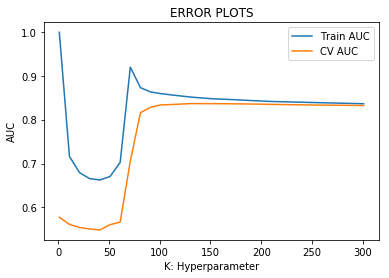

In [42]:
%%time
try:
    fig = mpimg.imread('fig_bow.png')
    plt.imshow(fig)
    cvs_bow=FromDiskP('cvs_bow')
    print('Load successful')
    print(cvs_bow)
except:    
    fig,cvs_bow = BestkBrute(xtr_bow,ytr,xcv_bow,ycv,1)
    fig.savefig('fig_bow.png',dpi=500)
    #mpimg.imsave('fig_bow.png', fig)
    ToDiskP(cvs_bow,'cvs_bow')
    print(cvs_bow)
    print('Save successful\n')

Accuracy on Test Data: 0.7106

Train confusion matrix


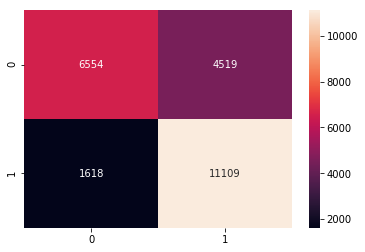


Test confusion matrix


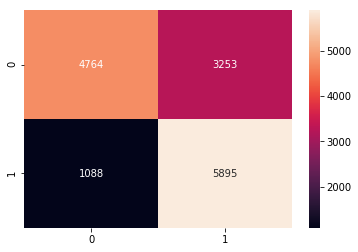

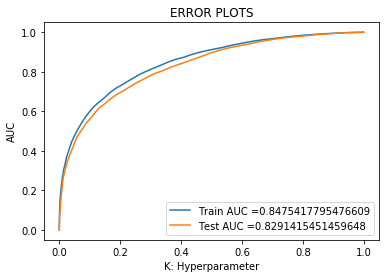

Wall time: 2min 6s


In [7]:
%%time
# K=151 as best K value 

knnb=KNeighborsClassifier(n_neighbors=151, n_jobs=1,algorithm='brute')
knnb.fit(xtr_bow,ytr)

ypre = knnb.predict(xte_bow)
print("Accuracy on Test Data:",(accuracy_score(yte, ypre)))

print("\nTrain confusion matrix")
cnf_tr=pd.DataFrame(confusion_matrix(ytr, knnb.predict(xtr_bow)))
ax=sns.heatmap(cnf_tr,annot=True,fmt='d')
plt.show()

print("\nTest confusion matrix")
cnf_tr=pd.DataFrame(confusion_matrix(yte, knnb.predict(xte_bow)))
ax=sns.heatmap(cnf_tr,annot=True,fmt='d')
plt.show()

trfpr,trtpr,thresholds = roc_curve(ytr, knnb.predict_proba(xtr_bow)[:,1])
tefpr,tetpr,thresholds = roc_curve(yte, knnb.predict_proba(xte_bow)[:,1])

plt.plot(trfpr, trtpr, label="Train AUC ="+str(auc(trfpr, trtpr)))
plt.plot(tefpr, tetpr, label="Test AUC ="+str(auc(tefpr, tetpr)))
plt.legend()
plt.xlabel("K: Hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


## [4.2] Bi-Grams and n-Grams.

In [8]:
%%time
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# you can choose these numebrs min_df=10, max_features=5000, of your choice

try:
    xtr_ngram = FromDiskM('xtr_ngram100k')
    xcv_ngram = FromDiskM('xcv_ngram100k')
    xte_ngram = FromDiskM('xte_ngram100k')
    print('Load successful.')
    
except:
    bigram_vect = CountVectorizer(ngram_range=(1,2), min_df=5)
    bigram_vect.fit(xtr)  # fit has to happen only on train data
    
    xtr_ngram = bigram_vect.transform(xtr)
    xcv_ngram = bigram_vect.transform(xcv)
    xte_ngram = bigram_vect.transform(xte)
    
    xtr_ngram=normalize(xtr_ngram)
    xcv_ngram=normalize(xcv_ngram)
    xte_ngram=normalize(xte_ngram)
    
    ToDiskM(xtr_ngram,'xtr_ngram100k')
    ToDiskM(xcv_ngram,'xcv_ngram100k')
    ToDiskM(xte_ngram,'xte_ngram100k')
    print('Save successful.')

Load successful.
Wall time: 212 ms


In [9]:
xtr_ngram.shape

(23800, 32582)

[{1: 0.5227565978652696}, {11: 0.5116242695249152}, {21: 0.5104928687719703}, {31: 0.5111811386295376}, {41: 0.5178830536177508}, {51: 0.5153528990305112}, {61: 0.5092032823799973}, {71: 0.5215239781345258}, {81: 0.8231582592063051}, {91: 0.8387127645623226}, {101: 0.8439876822789224}, {111: 0.8467757221587837}, {131: 0.8496845882951264}, {151: 0.84937125566548}, {171: 0.8485456868784764}, {191: 0.8479588279133442}, {211: 0.847379133761303}, {251: 0.8462937445424276}, {301: 0.8445883271121005}]
Save successful

Wall time: 13min 19s


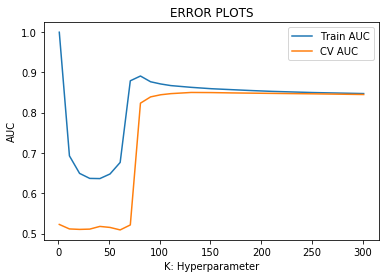

In [52]:
%%time
try:
    fig = mpimg.imread('fig_ngram.png')
    plt.imshow(fig)
    cvs_bow=FromDiskP('cvs_ngram')
    print('Load successful')
    print(cvs_ngram)
except:    
    fig, cvs_ngram = BestkBrute(xtr_ngram,ytr,xcv_ngram,ycv,1)
    fig.savefig('fig_ngram.png',dpi=500)
    #mpimg.imsave('fig_bow.png', fig)
    ToDiskP(cvs_ngram,'cvs_ngram')
    print(cvs_ngram)
    print('Save successful\n')

Accuracy on Test Data: 0.706

Train confusion matrix


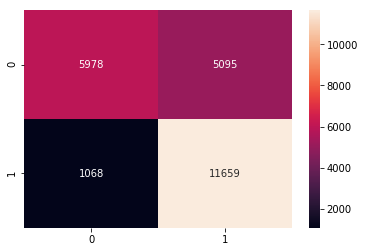


Test confusion matrix


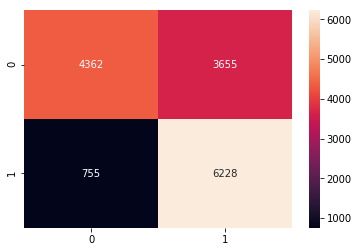

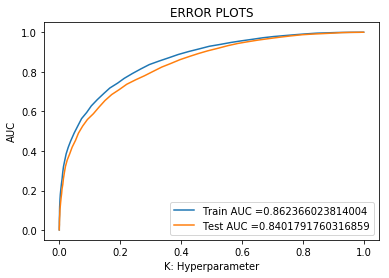

Wall time: 2min 7s


In [10]:
%%time
#K=131  as best K

knng=KNeighborsClassifier(n_neighbors=131, n_jobs=1, algorithm='brute')
knng.fit(xtr_ngram,ytr)

ypre = knng.predict(xte_ngram)
print("Accuracy on Test Data:",(accuracy_score(yte, ypre)))

print("\nTrain confusion matrix")
cnf_tr=pd.DataFrame(confusion_matrix(ytr, knng.predict(xtr_ngram)))
ax=sns.heatmap(cnf_tr,annot=True,fmt='d')
plt.show()

print("\nTest confusion matrix")
cnf_tr=pd.DataFrame(confusion_matrix(yte, knng.predict(xte_ngram)))
ax=sns.heatmap(cnf_tr,annot=True,fmt='d')
plt.show()

trfpr,trtpr,thresholds = roc_curve(ytr, knng.predict_proba(xtr_ngram)[:,1])
tefpr,tetpr,thresholds = roc_curve(yte, knng.predict_proba(xte_ngram)[:,1])

plt.plot(trfpr, trtpr, label="Train AUC ="+str(auc(trfpr, trtpr)))
plt.plot(tefpr, tetpr, label="Test AUC ="+str(auc(tefpr, tetpr)))
plt.legend()
plt.xlabel("K: Hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### [5.1.2] Applying KNN brute force on TFIDF,

## [4.3] TF-IDF

In [11]:
%%time

try:
    tfidf=FromDiskP('tfidf100k')    
    xtr_tfidf=FromDiskM('xtr_tfidf100k')
    xcv_tfidf=FromDiskM('xcv_tfidf100k')
    xte_tfidf=FromDiskM('xte_tfidf100k')
    print('Load successful.')
except:
    tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=5)
    tfidf.fit(xtr)
    
    xtr_tfidf=tfidf.transform(xtr)
    xcv_tfidf=tfidf.transform(xcv)
    xte_tfidf=tfidf.transform(xte)
    
    xtr_tfidf=normalize(xtr_tfidf)
    xcv_tfidf=normalize(xcv_tfidf)
    xte_tfidf=normalize(xte_tfidf)
    
    ToDiskM(xtr_tfidf,'xtr_tfidf100k')
    ToDiskM(xte_tfidf,'xte_tfidf100k')
    ToDiskM(xcv_tfidf,'xcv_tfidf100k')
    ToDiskP(tfidf,'tfidf100k')
    print('Save successful.')

Load successful.
Wall time: 494 ms


In [12]:
xte_tfidf.shape

(15000, 32582)

[{1: 0.5038678795671686}, {11: 0.49410383861258517}, {21: 0.4905317794644942}, {31: 0.4868052770127847}, {41: 0.4879600433727078}, {51: 0.484980280771113}, {61: 0.4972685269592085}, {71: 0.504975930706022}, {81: 0.8094687802865285}, {91: 0.8398668912067914}, {101: 0.8510209858654869}, {111: 0.8609884083559632}, {131: 0.8723190804730057}, {151: 0.8807560157242058}, {171: 0.8869158678219928}, {191: 0.8894271508033226}, {211: 0.8924074571630539}, {251: 0.8984427086831778}, {301: 0.9016121309241649}]
Save successful

Wall time: 12min 42s


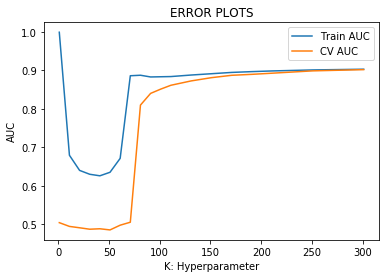

In [10]:
%%time
try:
    fig = mpimg.imread('fig_tfidf.png')
    plt.imshow(fig)
    cvs_tfidf=FromDiskP('cvs_tfidf')
    print('Load successful')
    print(cvs_tfidf)
except:    
    fig, cvs_tfidf = BestkBrute(xtr_tfidf,ytr,xcv_tfidf,ycv,1)
    fig.savefig('fig_tfidf.png',dpi=500)
    #mpimg.imsave('fig_bow.png', fig)
    ToDiskP(cvs_tfidf,'cvs_tfidf')
    print(cvs_tfidf)
    print('Save successful\n')

Accuracy on Test Data: 0.7506666666666667

Train confusion matrix


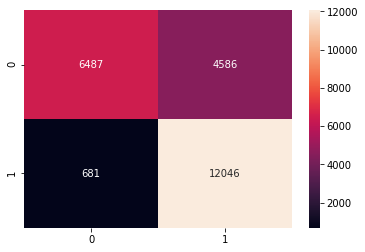


Test confusion matrix


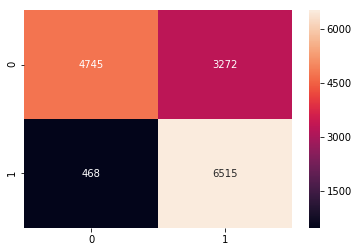

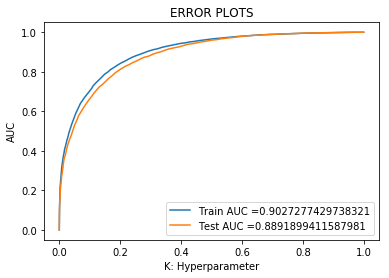

Wall time: 2min 13s


In [13]:
%%time
#K=301  as best K

knnt=KNeighborsClassifier(n_neighbors=301, n_jobs=1, algorithm='brute')
knnt.fit(xtr_tfidf,ytr)

ypre = knnt.predict(xte_tfidf)
print("Accuracy on Test Data:",(accuracy_score(yte, ypre)))

print("\nTrain confusion matrix")
cnf_tr=pd.DataFrame(confusion_matrix(ytr, knnt.predict(xtr_tfidf)))
ax=sns.heatmap(cnf_tr,annot=True,fmt='d')
plt.show()

print("\nTest confusion matrix")
cnf_tr=pd.DataFrame(confusion_matrix(yte, knnt.predict(xte_tfidf)))
ax=sns.heatmap(cnf_tr,annot=True,fmt='d')
plt.show()




trfpr,trtpr,thresholds = roc_curve(ytr, knnt.predict_proba(xtr_tfidf)[:,1])
tefpr,tetpr,thresholds = roc_curve(yte, knnt.predict_proba(xte_tfidf)[:,1])

plt.plot(trfpr, trtpr, label="Train AUC ="+str(auc(trfpr, trtpr)))
plt.plot(tefpr, tetpr, label="Test AUC ="+str(auc(tefpr, tetpr)))
plt.legend()
plt.xlabel("K: Hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


### [5.1.3] Applying KNN brute force on AVG W2V,

#### Avg W2v

In [38]:
#print(list_of_sentance[0:5])

In [14]:
w2v_model = Word2Vec.load('w2v_model.model')
list_of_sent_tr=[]
list_of_sent_cv=[]
list_of_sent_te=[]
for sentance in xtr:
    list_of_sent_tr.append(sentance.split())
for sentance in xcv:    
    list_of_sent_cv.append(sentance.split())
for sentance in xte:    
    list_of_sent_te.append(sentance.split())
    
w2v_words = list(w2v_model.wv.vocab)
#list_of_sentance=FromDiskP('list_of_sent')
print('Load successful')
#print('\n',w2v_model.wv.most_similar('book'))
#print('='*50)
#print('\n',w2v_model.wv.most_similar('yuck'))

Load successful


In [15]:
%%time
try:
    xtr_aw2v=FromDiskP('xtr_aw2v100k')
    xcv_aw2v=FromDiskP('xcv_aw2v100k')
    xte_aw2v=FromDiskP('xte_aw2v100k')
    print('Load successful.')

except:   
    xtr_aw2v = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sent_tr): # for each review/sentence
        sent_vec = np.zeros(100) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        count =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                count += 1
        if count != 0:
            sent_vec /= count
        xtr_aw2v.append(sent_vec)
    ToDiskP(xtr_aw2v,'xtr_aw2v100k')
    
    xcv_aw2v = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sent_cv): # for each review/sentence
        sent_vec = np.zeros(100) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        count =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                count += 1
        if count != 0:
            sent_vec /= count
        xcv_aw2v.append(sent_vec)
    ToDiskP(xcv_aw2v,'xcv_aw2v100k')
    
    
    xte_aw2v = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sent_te): # for each review/sentence
        sent_vec = np.zeros(100) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        count =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                count += 1
        if count != 0:
            sent_vec /= count
        xte_aw2v.append(sent_vec)    
    ToDiskP(xte_aw2v,'xte_aw2v100k')

    print('Save successful.')


Load successful.
Wall time: 398 ms


[{1: 0.7430344582729602}, {11: 0.8921812057996602}, {21: 0.9009954612188498}, {31: 0.9041831313431785}, {41: 0.9058112391608213}, {51: 0.9066746950956214}, {61: 0.9073055025124824}, {71: 0.9072429223481395}, {81: 0.907020541263246}, {91: 0.9065595942924587}, {101: 0.9067184996113729}, {111: 0.9067390664632372}, {131: 0.9064092931464085}, {151: 0.9060235927059644}, {171: 0.9055679073947908}, {191: 0.9053568172876704}, {211: 0.9051182514017766}, {251: 0.9046044479415556}, {301: 0.9041407501943136}]
Save successful

Wall time: 7min 8s


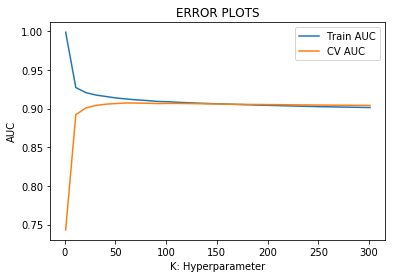

In [13]:
%%time
try:
    fig = mpimg.imread('fig_aw2v.png')
    plt.imshow(fig)
    cvs_aw2v=FromDiskP('cvs_aw2v')
    print('Load successful')
    print(cvs_aw2v)
except:    
    fig, cvs_aw2v = BestkBrute(xtr_aw2v,ytr,xcv_aw2v,ycv,1)
    fig.savefig('fig_aw2v.png',dpi=500)
    #mpimg.imsave('fig_bow.png', fig)
    ToDiskP(cvs_aw2v,'cvs_aw2v')
    print(cvs_aw2v)
    print('Save successful\n')

Accuracy on Test Data: 0.8123333333333334

Train confusion matrix


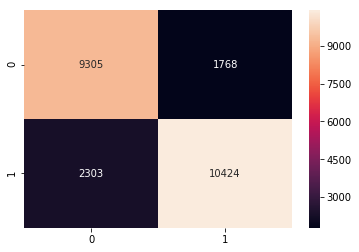


Test confusion matrix


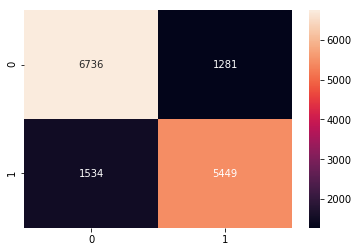

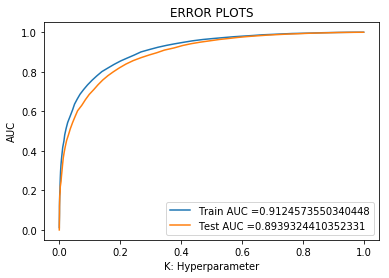

Wall time: 1min 5s


In [16]:
%%time
#K=61   as best K

knnaw=KNeighborsClassifier(n_neighbors=61, n_jobs=1, algorithm='brute')
knnaw.fit(xtr_aw2v,ytr)

ypre = knnaw.predict(xte_aw2v)
print("Accuracy on Test Data:",(accuracy_score(yte, ypre)))

print("\nTrain confusion matrix")
cnf_tr=pd.DataFrame(confusion_matrix(ytr, knnaw.predict(xtr_aw2v)))
ax=sns.heatmap(cnf_tr,annot=True,fmt='d')
plt.show()

print("\nTest confusion matrix")
cnf_tr=pd.DataFrame(confusion_matrix(yte, knnaw.predict(xte_aw2v)))
ax=sns.heatmap(cnf_tr,annot=True,fmt='d')
plt.show()


trfpr,trtpr,thresholds = roc_curve(ytr, knnaw.predict_proba(xtr_aw2v)[:,1])
tefpr,tetpr,thresholds = roc_curve(yte, knnaw.predict_proba(xte_aw2v)[:,1])

plt.plot(trfpr, trtpr, label="Train AUC ="+str(auc(trfpr, trtpr)))
plt.plot(tefpr, tetpr, label="Test AUC ="+str(auc(tefpr, tetpr)))
plt.legend()
plt.xlabel("K: Hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### [5.1.4] Applying KNN brute force on TFIDF W2V,

#### TFIDF weighted W2v

In [17]:
%%time
# TF-IDF weighted Word2Vec
dictionary = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))
try:
    xtr_tw2v=FromDiskP('xtr_tw2v100k')
    xcv_tw2v=FromDiskP('xcv_tw2v100k')
    xte_tw2v=FromDiskP('xte_tw2v100k')
    print('Load successful.')
    
except:
    tfidf_feat = tfidf.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

    xtr_tw2v = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sent_tr): #for each review/sentence 
        sent_vec = np.zeros(100) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        xtr_tw2v.append(sent_vec)
        row += 1
    ToDiskP(xtr_tw2v,'xtr_tw2v100k')
    
    xcv_tw2v = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sent_cv): #for each review/sentence 
        sent_vec = np.zeros(100) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        xcv_tw2v.append(sent_vec)
        row += 1
    ToDiskP(xcv_tw2v,'xcv_tw2v100k')
    
    
    
    xte_tw2v = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sent_te): #for each review/sentence 
        sent_vec = np.zeros(100) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        xte_tw2v.append(sent_vec)
        row += 1
    ToDiskP(xte_tw2v,'xte_tw2v100k')
    
    print('Save successful.')
print('exit')

Load successful.
exit
Wall time: 333 ms


[{1: 0.6995736296495318}, {11: 0.8458948819565058}, {21: 0.8549881332783178}, {31: 0.860043740544206}, {41: 0.8625564788781951}, {51: 0.8636672168219576}, {61: 0.8634125780852678}, {71: 0.8629442424009801}, {81: 0.8628591922312955}, {91: 0.8629306964262297}, {101: 0.8631474160293502}, {111: 0.862853194898909}, {131: 0.8639202402771248}, {151: 0.8632365923637166}, {171: 0.8634920627304974}, {191: 0.8635211058121347}, {211: 0.863524240417862}, {251: 0.8638095695034849}, {301: 0.8637792309980521}]
Save successful

Wall time: 7min 13s


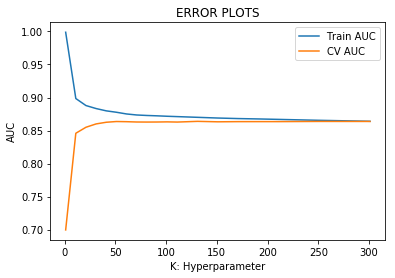

In [15]:
%%time
try:
    fig = mpimg.imread('fig_tw2v.png')
    plt.imshow(fig)
    cvs_tw2v=FromDiskP('cvs_tw2v')
    print('Load successful')
    print(cvs_tw2v)
except:    
    fig, cvs_tw2v = BestkBrute(xtr_tw2v,ytr,xcv_tw2v,ycv,1)
    fig.savefig('fig_tw2v.png',dpi=500)
    #mpimg.imsave('fig_bow.png', fig)
    ToDiskP(cvs_tw2v,'cvs_tw2v')
    print(cvs_tw2v)
    print('Save successful\n')

Accuracy on Test Data: 0.7579333333333333

Train confusion matrix


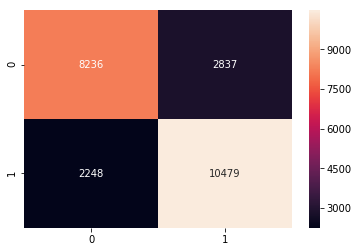


Test confusion matrix


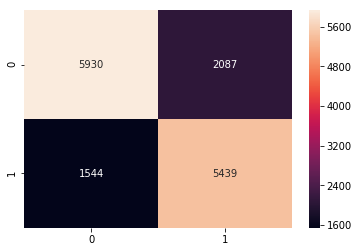

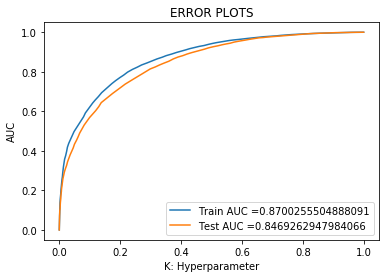

Wall time: 1min 8s


In [18]:
%%time
#K=131  as best K


knntw=KNeighborsClassifier(n_neighbors=131, n_jobs=1, algorithm='brute')
knntw.fit(xtr_tw2v,ytr)

ypre = knntw.predict(xte_tw2v)
print("Accuracy on Test Data:",(accuracy_score(yte, ypre)))

print("\nTrain confusion matrix")
cnf_tr=pd.DataFrame(confusion_matrix(ytr, knntw.predict(xtr_tw2v)))
ax=sns.heatmap(cnf_tr,annot=True,fmt='d')
plt.show()

print("\nTest confusion matrix")
cnf_tr=pd.DataFrame(confusion_matrix(yte, knntw.predict(xte_tw2v)))
ax=sns.heatmap(cnf_tr,annot=True,fmt='d')
plt.show()



trfpr,trtpr,thresholds = roc_curve(ytr, knntw.predict_proba(xtr_tw2v)[:,1])
tefpr,tetpr,thresholds = roc_curve(yte, knntw.predict_proba(xte_tw2v)[:,1])

plt.plot(trfpr, trtpr, label="Train AUC ="+str(auc(trfpr, trtpr)))
plt.plot(tefpr, tetpr, label="Test AUC ="+str(auc(tefpr, tetpr)))
plt.legend()
plt.xlabel("K: Hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

## [5.2] Applying KNN kd-tree

In [157]:
try:
    #final=FromDiskP('preprocessed_data100k')
    xtrkd=FromDiskP('xtr_kd')
    xtekd=FromDiskP('xte_kd')
    ytrkd=FromDiskP('ytr_kd')
    ytekd=FromDiskP('yte_kd')
    xcvkd=FromDiskP('xcv_kd')
    ycvkd=FromDiskP('ycv_kd')
    #print('Load Successful.')
    print('Load Successful.')

except:
    finalkd = final.sample(30000,random_state=2)
    print(finalkd['Score'].value_counts())
    finalkd.sort_values(by='Time',inplace=True)
    Y = finalkd['Score'].values
    X = finalkd['Text'].values
    #type(Y)
    xtrkd, xtekd, ytrkd, ytekd = train_test_split(X, Y, test_size=0.3, shuffle=False, random_state=1) # this is for time series split
    xtrkd, xcvkd, ytrkd, ycvkd = train_test_split(xtr, ytr, test_size=0.3, shuffle=False, random_state=3)
    #type(xte)
    ToDiskP(xtrkd,'xtr_kd')
    ToDiskP(xtekd,'xte_kd')
    ToDiskP(ytrkd,'ytr_kd')
    ToDiskP(ytekd,'yte_kd')
    ToDiskP(xcvkd,'xcv_kd')
    ToDiskP(ycvkd,'ycv_kd')
    print('Save successful.')

Load Successful.


### [5.2.1] Applying KNN kd-tree on BOW,

In [160]:
%%time
#BoW
try:
    xtr_bowkd=FromDiskP('xtr_bowkd')
    xcv_bowkd=FromDiskP('xcv_bowkd')
    xte_bowkd=FromDiskP('xte_bowkd')
    print('Load successful.')

except:
    vectorizer = CountVectorizer(ngram_range=(1,2), min_df=5, max_features=500) #in scikit-learn
    vectorizer.fit(xtrkd) # fit has to happen only on train data
    # we use the fitted CountVectorizer to convert the text to vector
    
    xtr_bowkd = vectorizer.transform(xtrkd)
    xcv_bowkd = vectorizer.transform(xcvkd)
    xte_bowkd = vectorizer.transform(xtekd)
    
    xtr_bowkd=xtr_bowkd.todense()
    xcv_bowkd=xcv_bowkd.todense()
    xte_bowkd=xte_bowkd.todense()
    
    xtr_bowkd=normalize(xtr_bowkd)
    xcv_bowkd=normalize(xcv_bowkd)
    xte_bowkd=normalize(xte_bowkd)
    
    ToDiskP(xtr_bowkd,'xtr_bowkd')
    ToDiskP(xcv_bowkd,'xcv_bowkd')
    ToDiskP(xte_bowkd,'xte_bowkd')
    print('Save successful.')

Save successful.
Wall time: 5.95 s


In [161]:
#xte_bowkd.shape
xtr_bowkd.shape

(16660, 500)

In [162]:
type(xte_bowkd)

numpy.ndarray

[{1: 0.6358376715393883}, {11: 0.6693164491763495}, {21: 0.6731313999541272}, {31: 0.6713886106956412}, {41: 0.6657262326820617}, {51: 0.6720555159593906}, {61: 0.742760852825802}, {71: 0.7799158093898597}, {81: 0.7930241976205317}, {91: 0.8018342288047674}, {101: 0.8053724598022637}, {111: 0.8081757139609661}, {131: 0.8108491809322063}, {151: 0.8118434967399012}, {171: 0.8111639580195732}, {191: 0.8101709369450057}, {211: 0.8101041993374263}, {251: 0.8094086137731827}, {301: 0.8079244180311911}]
Save successful

Wall time: 2h 13min 50s


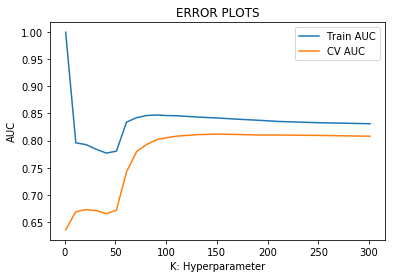

In [163]:
%%time
try:
    fig = mpimg.imread('fig_bowkd.png')
    plt.imshow(fig)
    cvs_bowkd=FromDiskP('cvs_bowkd')
    print('Load successful')
    print(cvs_bowkd)
except:    
    fig,cvs_bowkd = BestkKD(xtr_bowkd,ytrkd,xcv_bowkd,ycvkd,1)
    fig.savefig('fig_bowkd.png',dpi=500)
    #mpimg.imsave('fig_bow.png', fig)
    ToDiskP(cvs_bowkd,'cvs_bowkd')
    print(cvs_bowkd)
    print('Save successful\n')

Accuracy on Test Data: 0.7058888888888889

Train confusion matrix


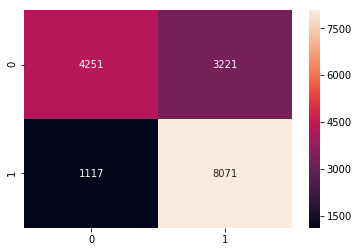


Test confusion matrix


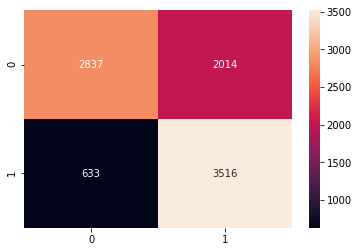

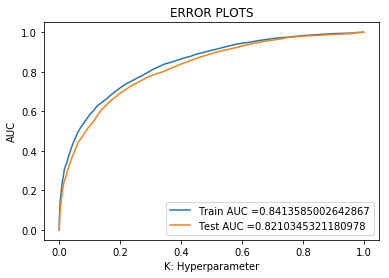

Wall time: 22min 24s


In [172]:
%%time
#k= 151 as best K


knnbkd=KNeighborsClassifier(n_neighbors=151, n_jobs=1, algorithm='kd_tree')
knnbkd.fit(xtr_bowkd,ytrkd)

ypre = knnbkd.predict(xte_bowkd)
print("Accuracy on Test Data:",(accuracy_score(ytekd, ypre)))

print("\nTrain confusion matrix")
cnf_tr=pd.DataFrame(confusion_matrix(ytrkd, knnbkd.predict(xtr_bowkd)))
ax=sns.heatmap(cnf_tr,annot=True,fmt='d')
plt.show()

print("\nTest confusion matrix")
cnf_tr=pd.DataFrame(confusion_matrix(ytekd, knnbkd.predict(xte_bowkd)))
ax=sns.heatmap(cnf_tr,annot=True,fmt='d')
plt.show()


trfpr,trtpr,thresholds = roc_curve(ytrkd, knnbkd.predict_proba(xtr_bowkd)[:,1])
tefpr,tetpr,thresholds = roc_curve(ytekd, knnbkd.predict_proba(xte_bowkd)[:,1])

plt.plot(trfpr, trtpr, label="Train AUC ="+str(auc(trfpr, trtpr)))
plt.plot(tefpr, tetpr, label="Test AUC ="+str(auc(tefpr, tetpr)))
plt.legend()
plt.xlabel("K: Hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### [5.2.2] Applying KNN kd-tree on TFIDF,

In [164]:
%%time

try:
    tfidfkd=FromDiskP('tfidfkd')    
    xtr_tfidfkd=FromDiskP('xtr_tfidfkd')
    xcv_tfidfkd=FromDiskP('xcv_tfidfkd')
    xte_tfidfkd=FromDiskP('xte_tfidfkd')
    print('Load successful.')
except:
    tfidfkd = TfidfVectorizer(ngram_range=(1,2), min_df=5, max_features=500)
    tfidfkd.fit(xtrkd)
    
    xtr_tfidfkd=tfidfkd.transform(xtrkd)
    xcv_tfidfkd=tfidfkd.transform(xcvkd)
    xte_tfidfkd=tfidfkd.transform(xtekd)
    
    xtr_tfidfkd=xtr_tfidfkd.todense()
    xcv_tfidfkd=xcv_tfidfkd.todense()
    xte_tfidfkd=xte_tfidfkd.todense()
    
    xtr_tfidfkd=normalize(xtr_tfidfkd)
    xcv_tfidfkd=normalize(xcv_tfidfkd)
    xte_tfidfkd=normalize(xte_tfidfkd)
    
    ToDiskP(xtr_tfidfkd,'xtr_tfidfkd')
    ToDiskP(xcv_tfidfkd,'xcv_tfidfkd')
    ToDiskP(xte_tfidfkd,'xte_tfidfkd')
    ToDiskP(tfidfkd,'tfidfkd')
    print('Save successful.')

Save successful.
Wall time: 5.14 s


In [46]:
xtr_tfidfkd.shape

(16184, 500)

[{1: 0.569249546784554}, {11: 0.5604717269911603}, {21: 0.5702535534735375}, {31: 0.5674628935370767}, {41: 0.5709990451147012}, {51: 0.5672465554017482}, {61: 0.7092748560707957}, {71: 0.7728407598310068}, {81: 0.7960711754819291}, {91: 0.8046467815013866}, {101: 0.8126753431572453}, {111: 0.8158966784131656}, {131: 0.8213099968541908}, {151: 0.8225712630922041}, {171: 0.8237984346911893}, {191: 0.8249690696102673}, {211: 0.8254341142091155}, {251: 0.8298573541508634}, {301: 0.832594419982707}]
Save successful

Wall time: 2h 13min 27s


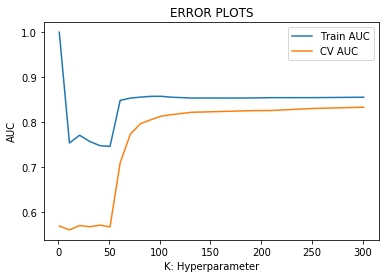

In [166]:
%%time
try:
    fig = mpimg.imread('fig_tfidfkd.png')
    plt.imshow(fig)
    cvs_tfidfkd=FromDiskP('cvs_tfidfkd')
    print('Load successful')
    print(cvs_tfidfkd)
except:    
    fig,cvs_tfidfkd = BestkKD(xtr_tfidfkd,ytrkd,xcv_tfidfkd,ycvkd,1)
    fig.savefig('fig_tfidfkd.png',dpi=500)
    #mpimg.imsave('fig_bow.png', fig)
    ToDiskP(cvs_tfidfkd,'cvs_tfidfkd')
    print(cvs_tfidfkd)
    print('Save successful\n')

Accuracy on Test Data: 0.6916666666666667

Train confusion matrix


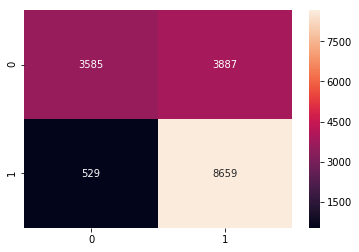


Test confusion matrix


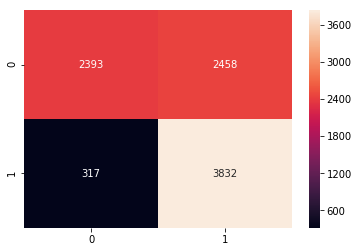

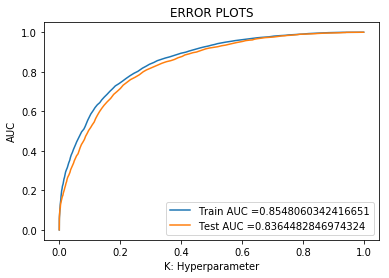

Wall time: 24min 8s


In [176]:
%%time
#K=301  as best K


knntkd=KNeighborsClassifier(n_neighbors=301, n_jobs=1, algorithm='kd_tree')
knntkd.fit(xtr_tfidfkd,ytrkd)

ypre = knntkd.predict(xte_tfidfkd)
print("Accuracy on Test Data:",(accuracy_score(ytekd, ypre)))

print("\nTrain confusion matrix")
cnf_tr=pd.DataFrame(confusion_matrix(ytrkd, knntkd.predict(xtr_tfidfkd)))
ax=sns.heatmap(cnf_tr,annot=True,fmt='d')
plt.show()

print("\nTest confusion matrix")
cnf_tr=pd.DataFrame(confusion_matrix(ytekd, knntkd.predict(xte_tfidfkd)))
ax=sns.heatmap(cnf_tr,annot=True,fmt='d')
plt.show()


trfpr,trtpr,thresholds = roc_curve(ytrkd, knntkd.predict_proba(xtr_tfidfkd)[:,1])
tefpr,tetpr,thresholds = roc_curve(ytekd, knntkd.predict_proba(xte_tfidfkd)[:,1])

plt.plot(trfpr, trtpr, label="Train AUC ="+str(auc(trfpr, trtpr)))
plt.plot(tefpr, tetpr, label="Test AUC ="+str(auc(tefpr, tetpr)))
plt.legend()
plt.xlabel("K: Hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### [5.2.3] Applying KNN kd-tree on AVG W2V,

In [167]:
#w2v_model = Word2Vec.load('w2v_model.model')
list_of_sent_tr=[]
list_of_sent_cv=[]
list_of_sent_te=[]
for sentance in xtrkd:
    list_of_sent_tr.append(sentance.split())
for sentance in xcvkd:    
    list_of_sent_cv.append(sentance.split())
for sentance in xtekd:    
    list_of_sent_te.append(sentance.split())
    
w2v_words = list(w2v_model.wv.vocab)
#list_of_sentance=FromDiskP('list_of_sent')
print('Load successful')
#print('\n',w2v_model.wv.most_similar('book'))
#print('='*50)
#print('\n',w2v_model.wv.most_similar('yuck'))

Load successful


In [168]:
%%time
try:
    xtr_aw2vkd=FromDiskP('xtr_aw2vkd')
    xcv_aw2vkd=FromDiskP('xcv_aw2vkd')
    xte_aw2vkd=FromDiskP('xte_aw2vkd')
    print('Load successful.')

except:   
    xtr_aw2vkd = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sent_tr): # for each review/sentence
        sent_vec = np.zeros(100) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        count =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                count += 1
        if count != 0:
            sent_vec /= count
        xtr_aw2vkd.append(sent_vec)
    ToDiskP(xtr_aw2vkd,'xtr_aw2vkd')
    
    xcv_aw2vkd = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sent_cv): # for each review/sentence
        sent_vec = np.zeros(100) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        count =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                count += 1
        if count != 0:
            sent_vec /= count
        xcv_aw2vkd.append(sent_vec)
    ToDiskP(xcv_aw2vkd,'xcv_aw2vkd')
    
    
    xte_aw2vkd = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sent_te): # for each review/sentence
        sent_vec = np.zeros(100) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        count =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                count += 1
        if count != 0:
            sent_vec /= count
        xte_aw2vkd.append(sent_vec)    
    ToDiskP(xte_aw2vkd,'xte_aw2vkd')

    print('Save successful.')


100%|█████████████████████████████████████████████████████████████████████████████| 9000/9000 [00:13<00:00, 685.47it/s]


Save successful.
Wall time: 47.1 s


[{1: 0.7310794566734821}, {11: 0.8794987562322764}, {21: 0.8909108871283831}, {31: 0.8930217729384926}, {41: 0.8953012486955563}, {51: 0.8960374810331405}, {61: 0.8964003986522535}, {71: 0.8960443862764881}, {81: 0.8964038905082643}, {91: 0.8962178805155926}, {101: 0.8961590682441276}, {111: 0.8965000146344079}, {131: 0.8959737252351883}, {151: 0.895300817117847}, {171: 0.8948051697359819}, {191: 0.8940856512260457}, {211: 0.8931993867830034}, {251: 0.8921191870111744}, {301: 0.8915668460120532}]
Save successful

Wall time: 57min 24s


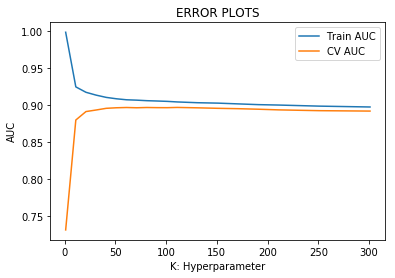

In [169]:
%%time
try:
    fig = mpimg.imread('fig_aw2vkd.png')
    plt.imshow(fig)
    cvs_aw2vkd=FromDiskP('cvs_aw2vkd')
    print('Load successful')
    print(cvs_aw2vkd)
except:    
    fig,cvs_aw2vkd = BestkKD(xtr_aw2vkd,ytrkd,xcv_aw2vkd,ycvkd,1)
    fig.savefig('fig_aw2vkd.png',dpi=500)
    #mpimg.imsave('fig_bow.png', fig)
    ToDiskP(cvs_aw2vkd,'cvs_aw2vkd')
    print(cvs_aw2vkd)
    print('Save successful\n')

Accuracy on Test Data: 0.8023333333333333

Train confusion matrix


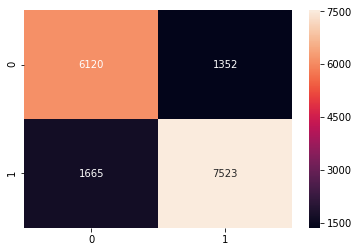


Test confusion matrix


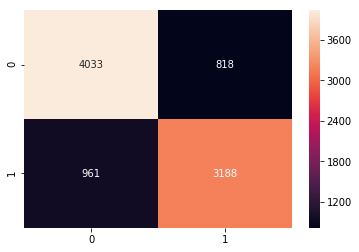

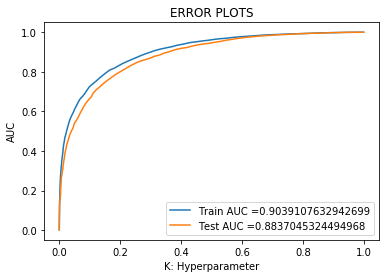

Wall time: 5min 59s


In [174]:
%%time
#K=111  as best K


knnawkd=KNeighborsClassifier(n_neighbors=111, n_jobs=1, algorithm='kd_tree')
knnawkd.fit(xtr_aw2vkd,ytrkd)

ypre = knnawkd.predict(xte_aw2vkd)
print("Accuracy on Test Data:",(accuracy_score(ytekd, ypre)))

print("\nTrain confusion matrix")
cnf_tr=pd.DataFrame(confusion_matrix(ytrkd, knnawkd.predict(xtr_aw2vkd)))
ax=sns.heatmap(cnf_tr,annot=True,fmt='d')
plt.show()

print("\nTest confusion matrix")
cnf_tr=pd.DataFrame(confusion_matrix(ytekd, knnawkd.predict(xte_aw2vkd)))
ax=sns.heatmap(cnf_tr,annot=True,fmt='d')
plt.show()


trfpr,trtpr,thresholds = roc_curve(ytrkd, knnawkd.predict_proba(xtr_aw2vkd)[:,1])
tefpr,tetpr,thresholds = roc_curve(ytekd, knnawkd.predict_proba(xte_aw2vkd)[:,1])

plt.plot(trfpr, trtpr, label="Train AUC ="+str(auc(trfpr, trtpr)))
plt.plot(tefpr, tetpr, label="Test AUC ="+str(auc(tefpr, tetpr)))
plt.legend()
plt.xlabel("K: Hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### [5.2.4] Applying KNN kd-tree on TFIDF W2V,

In [170]:
%%time
# TF-IDF weighted Word2Vec
dictionary = dict(zip(tfidfkd.get_feature_names(), list(tfidfkd.idf_)))
try:
    xtr_tw2vkd=FromDiskP('xtr_tw2vkd')
    xcv_tw2vkd=FromDiskP('xcv_tw2vkd')
    xte_tw2vkd=FromDiskP('xte_tw2vkd')
    print('Load successful.')
    
except:
    tfidf_feat = tfidfkd.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

    xtr_tw2vkd = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sent_tr): #for each review/sentence 
        sent_vec = np.zeros(100) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        xtr_tw2vkd.append(sent_vec)
        row += 1
    ToDiskP(xtr_tw2vkd,'xtr_tw2vkd')
    
    xcv_tw2vkd = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sent_cv): #for each review/sentence 
        sent_vec = np.zeros(100) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        xcv_tw2vkd.append(sent_vec)
        row += 1
    ToDiskP(xcv_tw2vkd,'xcv_tw2vkd')
    
    
    
    xte_tw2vkd = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sent_te): #for each review/sentence 
        sent_vec = np.zeros(100) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        xte_tw2vkd.append(sent_vec)
        row += 1
    ToDiskP(xte_tw2vkd,'xte_tw2vkd')
    
    print('Save successful.')
print('exit')

100%|█████████████████████████████████████████████████████████████████████████████| 9000/9000 [00:19<00:00, 465.97it/s]


Save successful.
exit
Wall time: 1min 8s


[{1: 0.658115516717398}, {11: 0.7950583018327381}, {21: 0.8064501485765113}, {31: 0.8078916573596281}, {41: 0.8096253834862205}, {51: 0.8123420474627194}, {61: 0.8133220427373358}, {71: 0.8134268376520007}, {81: 0.8127425515768713}, {91: 0.8133247106722654}, {101: 0.8134433553079624}, {111: 0.8131305399374557}, {131: 0.8135541923105564}, {151: 0.8129085128232332}, {171: 0.8130656071093875}, {191: 0.8123185853290729}, {211: 0.8115916122950683}, {251: 0.8113303116093069}, {301: 0.8102353597266905}]
Save successful

Wall time: 41min 55s


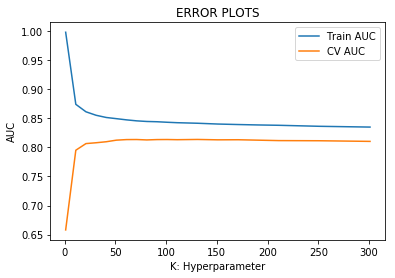

In [171]:
%%time
try:
    fig = mpimg.imread('fig_tw2vkd.png')
    plt.imshow(fig)
    cvs_tw2vkd=FromDiskP('cvs_tw2vkd')
    print('Load successful')
    print(cvs_tw2vkd)
except:    
    fig,cvs_tw2vkd = BestkKD(xtr_tw2vkd,ytrkd,xcv_tw2vkd,ycvkd,1)
    fig.savefig('fig_tw2vkd.png',dpi=500)
    #mpimg.imsave('fig_bow.png', fig)
    ToDiskP(cvs_tw2vkd,'cvs_tw2vkd')
    print(cvs_tw2vkd)
    print('Save successful\n')

Accuracy on Test Data: 0.7324444444444445

Train confusion matrix


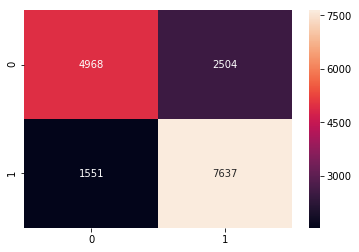


Test confusion matrix


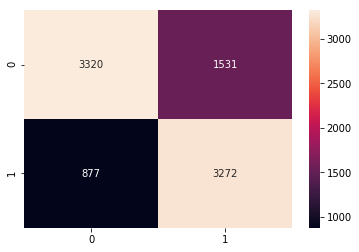

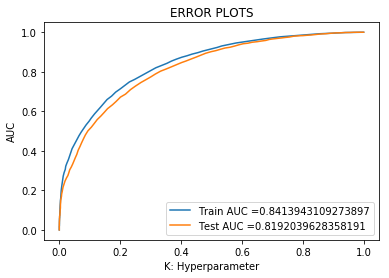

Wall time: 7min 8s


In [175]:
%%time
#K=131  as best K

knntwkd=KNeighborsClassifier(n_neighbors=131, n_jobs=1, algorithm='kd_tree')
knntwkd.fit(xtr_tw2vkd,ytrkd)

ypre = knntwkd.predict(xte_tw2vkd)
print("Accuracy on Test Data:",(accuracy_score(ytekd, ypre)))

print("\nTrain confusion matrix")
cnf_tr=pd.DataFrame(confusion_matrix(ytrkd, knntwkd.predict(xtr_tw2vkd)))
ax=sns.heatmap(cnf_tr,annot=True,fmt='d')
plt.show()

print("\nTest confusion matrix")
cnf_tr=pd.DataFrame(confusion_matrix(ytekd, knntwkd.predict(xte_tw2vkd)))
ax=sns.heatmap(cnf_tr,annot=True,fmt='d')
plt.show()


trfpr,trtpr,thresholds = roc_curve(ytrkd, knntwkd.predict_proba(xtr_tw2vkd)[:,1])
tefpr,tetpr,thresholds = roc_curve(ytekd, knntwkd.predict_proba(xte_tw2vkd)[:,1])

plt.plot(trfpr, trtpr, label="Train AUC ="+str(auc(trfpr, trtpr)))
plt.plot(tefpr, tetpr, label="Test AUC ="+str(auc(tefpr, tetpr)))
plt.legend()
plt.xlabel("K: Hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

# [6] Conclusions

I took 30k random datapoints(15k +ve, 15k-ve) for generating bow, tf-idf, avg-w2v & tf-idf-w2v vectors.

I've trained w2v model on 500k datapoints (size=100), and saved model on disk.

In [177]:
from prettytable import PrettyTable
table = PrettyTable(['Vectorizer', 'Model', 'Hyperparameter-K', 'AUC_Score', 'Accuracy'])
#x.set_field_align("City name", "l") # Left align city names
#x.set_padding_width(1) # One space between column edges and contents (default)
table.add_row(['BOW','Brute',151,0.82915,0.7106])
table.add_row(['BOW-bigram','Brute',131,0.84018,0.706])
table.add_row(['BOW-bigram','KD-Tree', 151, 0.82104, 0.70589])
table.add_row(['TF-IDF','Brute', 301, 0.88919,0.75067])
table.add_row(['TF-IDF','KD-Tree',301,0.83645,0.69167])
table.add_row(['AvgW2V','Brute',61,0.89394,0.81234])
table.add_row(['AvgW2V','KD-Tree',111,0.88371,0.80234])
table.add_row(['TF-IDF W2V','Brute',131,0.84693,0.75794])
table.add_row(['TF-IDF W2V','KD-Tree',131,0.81921,0.73245])
print (table)

+------------+---------+------------------+-----------+----------+
| Vectorizer |  Model  | Hyperparameter-K | AUC_Score | Accuracy |
+------------+---------+------------------+-----------+----------+
|    BOW     |  Brute  |       151        |  0.82915  |  0.7106  |
| BOW-bigram |  Brute  |       131        |  0.84018  |  0.706   |
| BOW-bigram | KD-Tree |       151        |  0.82104  | 0.70589  |
|   TF-IDF   |  Brute  |       301        |  0.88919  | 0.75067  |
|   TF-IDF   | KD-Tree |       301        |  0.83645  | 0.69167  |
|   AvgW2V   |  Brute  |        61        |  0.89394  | 0.81234  |
|   AvgW2V   | KD-Tree |       111        |  0.88371  | 0.80234  |
| TF-IDF W2V |  Brute  |       131        |  0.84693  | 0.75794  |
| TF-IDF W2V | KD-Tree |       131        |  0.81921  | 0.73245  |
+------------+---------+------------------+-----------+----------+


1) I took 50k data points for brute_force KNN and 30k data points for KD_Tree version of KNN.

2) KD_Tree version of KNN takes more time to run, compared to BruteForce. I implemented simple cross validation.

3) Avgw2v BruteForce gives best AUC_Score.

4) TF-IDFw2v BruteForce & TF-IDFw2v KD-Tree gives similar results.

5) Simple cross validation takes less time for avgw2v & tfidfw2v compared to bow & tfidf.

6) roc_auc_score metric is used for finding best K value.